# Define the low-$\alpha$ sample to model

In [ ]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm 
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax


In [2]:
# LOAD THE DATA
path = '/Users/dhortad/Documents/Data/allstar-dr17-StarHorse-Gaiadr3-astroNNages'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

554738


In [3]:
# remove GC stars
path_gc = '/Users/dhortad/Documents/Data/GC_members_VAC-v1_1.fits'
tb_gc = fits.open(path_gc)
data_gc = tb_gc[1].data
gc_stars_vac = data_gc.field('APOGEE_ID')
print('There are '+str(len(gc_stars_vac))+' GC stars')

There are 7737 GC stars


In [4]:
apo_id = data['APOGEE_ID']
mask_gcs = np.isin(list(data['APOGEE_ID']),list(gc_stars_vac))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

np.int64(536530)

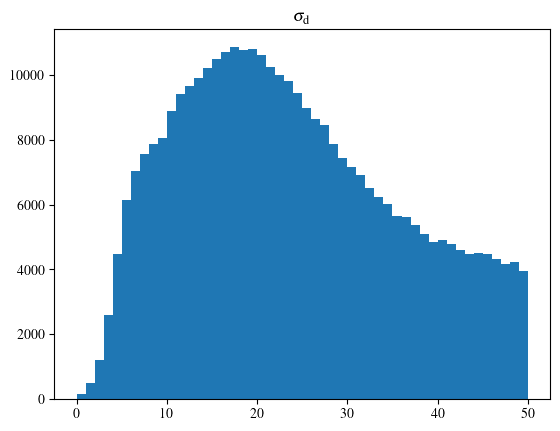

In [6]:
# check the distance errors
dist= data['dist50']
dist_err = (data['dist84']-data['dist16'])/2.

plt.title(r'$\sigma_{\mathrm{d}}$')
plt.hist(dist/dist_err, bins=np.linspace(0,50,51));
plt.show()

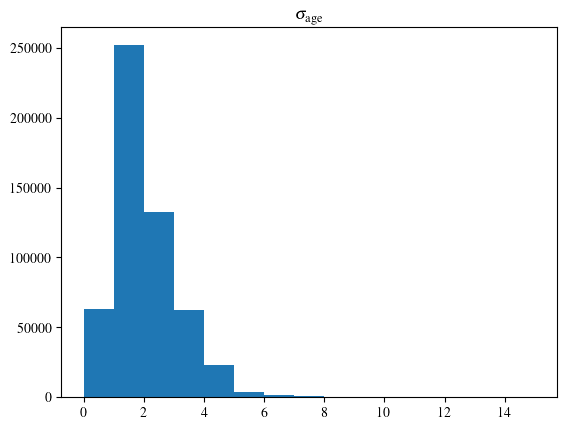

In [7]:
# check the age errors
age_err = np.sqrt(data['age_total_error']**2+data['age_model_error']**2)

plt.title(r'$\sigma_{\mathrm{age}}$')
plt.hist(age_err,bins=np.linspace(0,15,16));
plt.show()

In [8]:
# create the parent mask
mask = (data['SNR']>20)&(data['LOGG']<3.6)&(data['TEFF']>3000.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(starflag_mask)&(aspcapflag_mask) & (dist/dist_err>5)
    # & (age_err<2)
    
print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 318868 stars in the parent sample


In [9]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
rads = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2+data['xyz'][:,2]**2)
vcirc = 229.-1.7*(Rgal-8.275)
vcirc2 = 250.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
Rg2 = -(data['L'][:,2]/vcirc2)
deltaR = Rgal-Rg
deltaR2 = Rgal-Rg2
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vR = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

LR = (-z*vt) 
Lphi = (z.value*vR - Rgal*vz.value) 
Lz = Rgal * vt


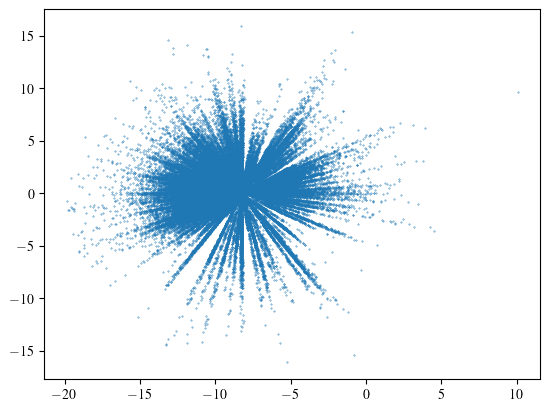

In [16]:
plt.scatter(x[wmask_all], y[wmask_all], s=0.1)

In [11]:
# do a selection in Mg/Mn-Al/Fe

line = data['FE_H']*-0.167 + 0.12
lowa_disc_mask = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))
mask_al = (data['AL_FE']>-0.12)&(data['AL_FE']<0.35)
age_mask = (data['age_lowess_correct']<2.)&(age_err<1.) # this is to select stars that haven't had much time to suffer from radial migration 

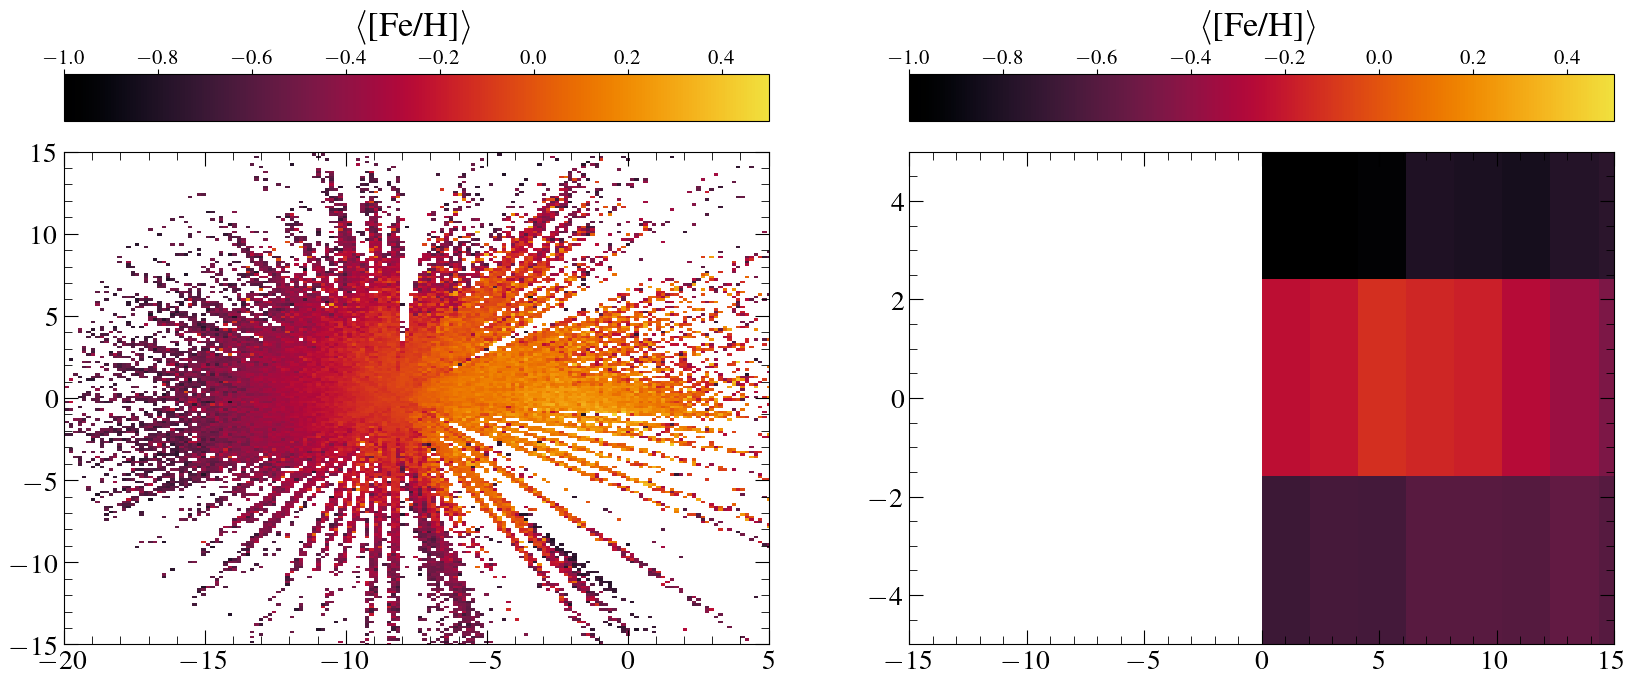

In [12]:
from scipy import stats

fig = plt.figure(figsize=(20,8), facecolor='white')

abun = data["FE_H"]
plt.subplot(1,2,1)
binx = np.linspace(np.min(x[mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)]),np.max(x[mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)]),256)
biny = np.linspace(np.min(y[mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)]),np.max(y[mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)]),256)    
hist = stats.binned_statistic_2d(x[mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)],y[mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)], data["FE_H"][mask&(abun>-10)&lowa_disc_mask&(np.abs(Rgal)<20)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1.,vmax=0.5)
plt.xlim(-20,5)
plt.ylim(-15,15)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


plt.subplot(1,2,2)
binx = np.linspace(np.min(Rgal[mask&(abun>-10)]),np.max(Rgal[mask&(abun>-10)]),128)
biny = np.linspace(np.min(z[mask&(abun>-10)]),np.max(z[mask&(abun>-10)]),128)    
hist = stats.binned_statistic_2d(Rgal[mask&(abun>-10)],z[mask&(abun>-10)], data["FE_H"][mask&(abun>-10)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-1,vmax=0.5)
plt.xlim(-15,15)
plt.ylim(-5,5)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')




In [14]:
# wmask = mask&lowa_disc_mask&mask_al&(rads<20.)
omask = (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<2)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<80) # vr of 50 here caused we checked deltaR in Vr and found it is around 50
wmask_all = mask&omask&lowa_disc_mask&(Rgal<20)&mask_al
print(len(data[wmask_all]))

86939


In [65]:
mgmn = data['MG_FE'] - data['MN_FE']

Text(0, 0.5, '[Mg/Mn]')

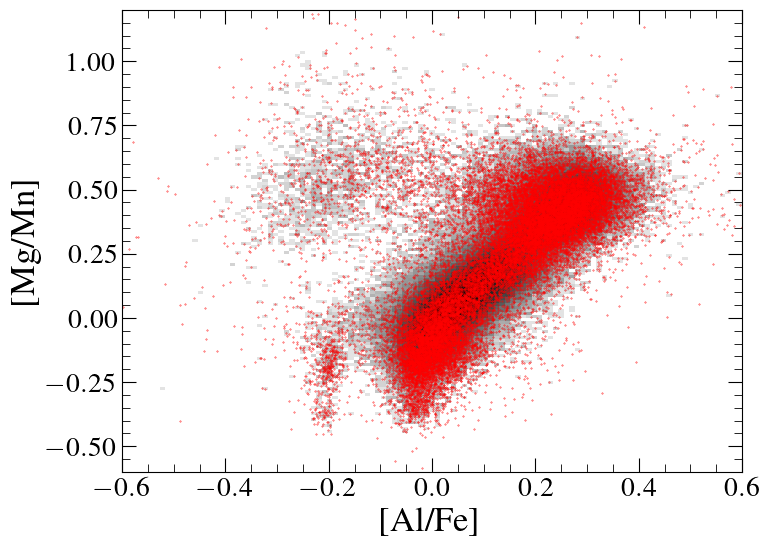

In [84]:
from matplotlib.colors import LogNorm
# check the z-vz plane
mask_plot  = (np.abs(mgmn)<2)&(np.abs(data['AL_FE'])<2)&(data['FE_H']>-1.7)&(rads<10)

plt.figure(figsize=(8,6), facecolor='white')
plt.hist2d(data['AL_FE'][mask&mask_plot], mgmn[mask&mask_plot],bins=250, cmap='binary', norm = LogNorm())
plt.scatter(data['AL_FE'][mask&mask_plot&(rads<5)], mgmn[mask&mask_plot&(rads<5)],s=0.1,c='r')
plt.xlim(-0.6,0.6) 
plt.ylim(-0.6,1.2)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'[Al/Fe]', fontsize=25)
plt.ylabel(r'[Mg/Mn]', fontsize=25)
# plt.ylim(-150,150)
# plt.xlim(-5,5)

In [26]:
print(np.nanmedian(deltaR[wmask_all]), np.nanmedian(deltaR2[wmask_all]))

-0.006564073958846617 0.7565940388976942


(-5.0, 5.0)

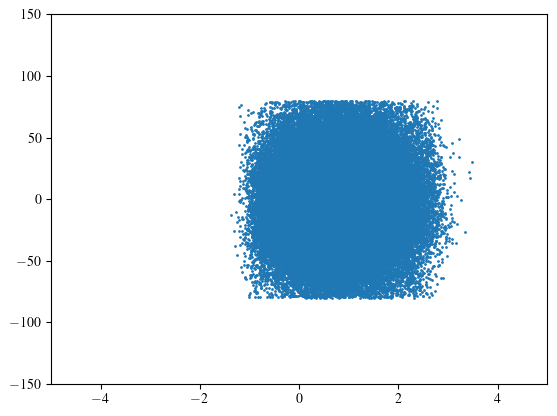

In [27]:
# check the z-vz plane
plt.scatter(deltaR2[wmask_all], vR[wmask_all],s=1)
plt.ylim(-150,150)
plt.xlim(-5,5)

(-2.0, 2.0)

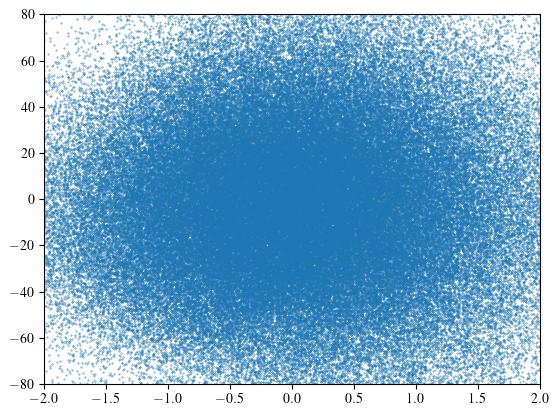

In [480]:
# check the z-vz plane
plt.scatter(deltaR[lowa_disc_mask&mask&mask_al], vR[lowa_disc_mask&mask&mask_al],s=0.1)
plt.ylim(-80,80)
plt.xlim(-2,2)

77740


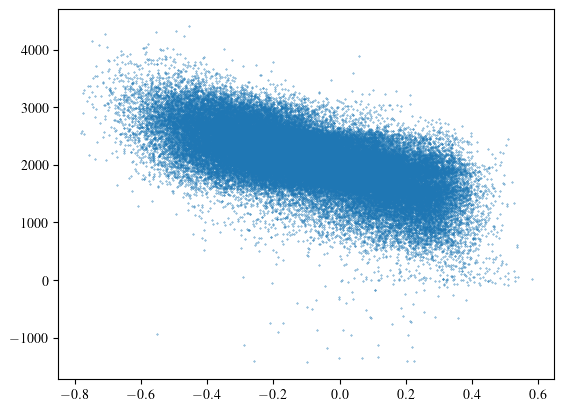

In [481]:
plt.scatter(data['FE_H'][wmask_all], Lz[wmask_all],s=0.1)
# plt.ylim(0,100)
# plt.xlim(0,20)
print(len(Rgal[wmask_all]))
# plt.yscale('log')

In [444]:
def power(xs, n, a):
    return a*xs**-n

def line(xs, m, b):
    return xs *m + b

In [455]:
from scipy.optimize import curve_fit
mask_rad = (Rgal>4)&(Rgal<20)
# popt, pcov = curve_fit(power, data['FE_H'][wmask_all&mask_rad], vt[wmask_all&mask_rad]/Rgal[wmask_all&mask_rad])
popt2, pcov2 = curve_fit(line, data['FE_H'][wmask_all&mask_rad],Lz[wmask_all&mask_rad])
popt2

array([-1558.91991682,  1975.45492144])

41736


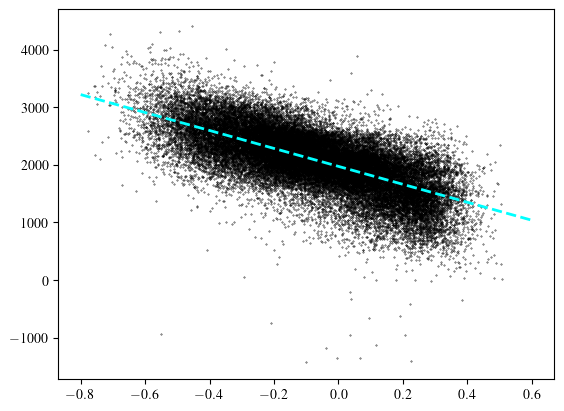

In [456]:
xs = np.linspace(-0.8,0.6,128)

plt.scatter(data['FE_H'][wmask_all], Lz[wmask_all],s=0.1, c='k')
# plt.plot(xs, power(xs, popt[0], popt[1]), ls='dashed', color='r', lw=2)
plt.plot(xs, line(xs, popt2[0], popt2[1]), ls='dashed', color='cyan', lw=2)
# plt.ylim(0,100)
# plt.xlim(0,20)
print(len(Rgal[wmask_all]))
# plt.yscale('log')

In [460]:
rgs = np.linspace(0,20,21)
delta = (rgs[1]-rgs[0])/2.

lzs = np.zeros((len(rgs)))

for indx, i in enumerate(rgs):
    mask_bin = (Rgal>i)&(Rgal<i+delta)
    mean_feh = np.nanmean(data['FE_H'][wmask_all&mask_bin])
    lzs[indx] = line(mean_feh, popt2[0], popt2[1])
    


(array([   34.,   426.,  3179.,  6816., 16187., 11087.,  3358.,   514.,
          102.,    33.]),
 array([ 0.09368319,  2.07121976,  4.04875632,  6.02629289,  8.00382946,
         9.98136603, 11.9589026 , 13.93643917, 15.91397574, 17.89151231,
        19.86904888]),
 <BarContainer object of 10 artists>)

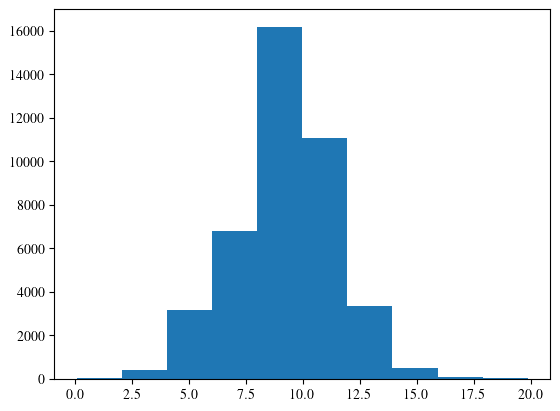

In [464]:
plt.hist(Rgal[wmask_all])

(0.0, 400.0)

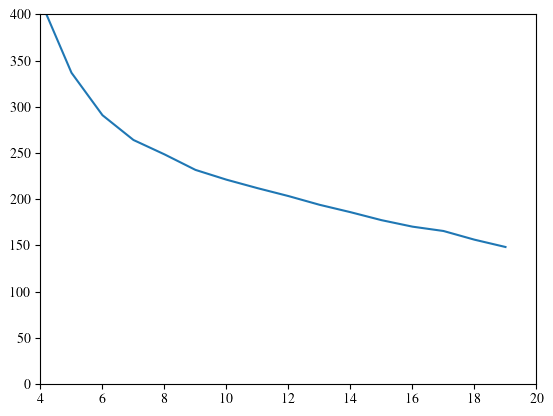

In [466]:
plt.plot(rgs, lzs/rgs)
plt.xlim(4,20)
plt.ylim(0,400)

In [15]:
np.save('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-last',wmask_all)

Text(0, 0.5, '$\\log(v_{\\phi}/R)$')

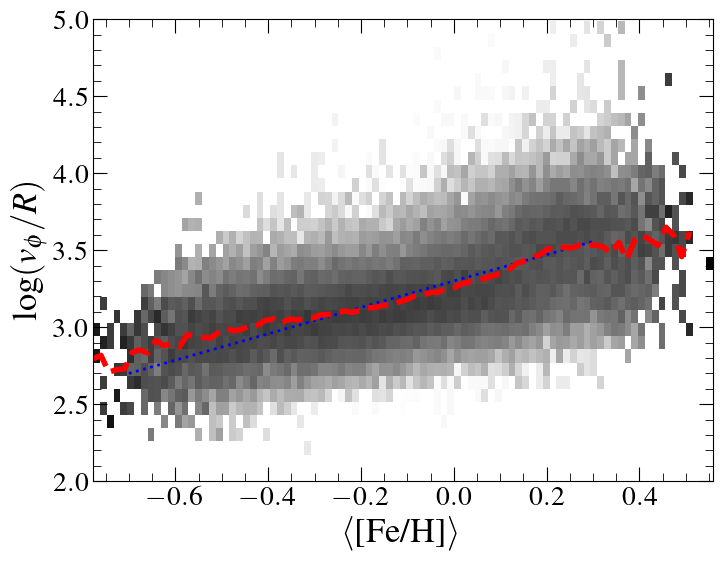

In [349]:
xs = np.linspace(-0.7,0.3, 128)
ys = 0.857*xs + 3.3
vphi_R = np.log(vt/Rgal)


plt.figure(figsize=(8,6))
biny = np.linspace(np.min(vphi_R[wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.max(vphi_R[wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)
binx = np.linspace(np.nanmin(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.nanmax(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)    
hist, xedges, yedges = np.histogram2d(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)],vphi_R[wmask_all&(np.abs(abun)<3)&(Lz>0)], bins=91)
hist = hist.T
hist = hist / hist.sum(axis=0)[None]
    
means,zs = running_mean(data['FE_H'][wmask_all&(abun>-10)&(Lz>0)],vphi_R[wmask_all&(abun>-10)&(Lz>0)])

plt.plot(xs, ys, lw=2. ,c='b', ls='dotted')
plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
# plt.xlim(10,70)
plt.ylim(2,5)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$\langle$[Fe/H]$\rangle$', fontsize=25)
plt.ylabel(r'$\log(v_{\phi}/R)$', fontsize=25)

Text(0, 0.5, '$\\log(v_{\\phi}/R_g)$')

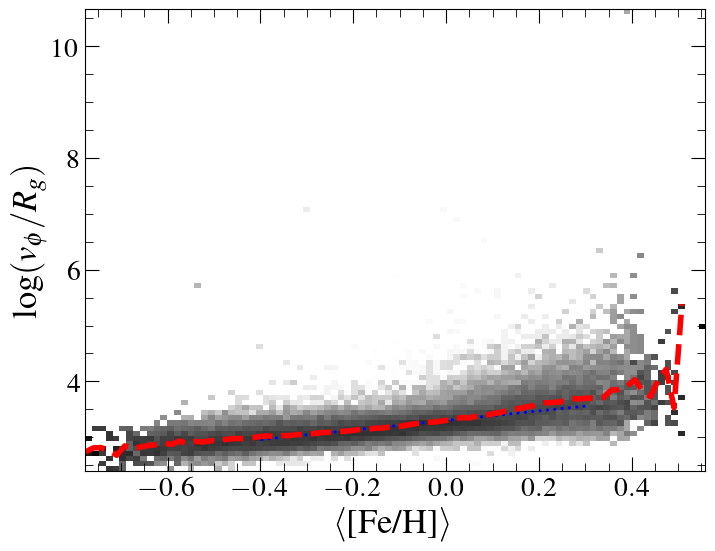

In [350]:
xs = np.linspace(-0.4,0.3, 128)
ys = 0.857*xs + 3.3
vphi_Rg = np.log(229./Rg)


plt.figure(figsize=(8,6))
biny = np.linspace(np.nanmin(vphi_Rg[wmask_all&(np.abs(abun)<3)&(~np.isnan(vphi_Rg))]),np.nanmax(vphi_Rg[wmask_all&(np.abs(abun)<3)&(~np.isnan(vphi_Rg))]),nbins)
binx = np.linspace(np.nanmin(data['FE_H'][wmask_all&(np.abs(abun)<3)&(~np.isnan(vphi_Rg))]),np.nanmax(data['FE_H'][wmask_all&(np.abs(abun)<3)&(~np.isnan(vphi_Rg))]),nbins)    
hist, xedges, yedges = np.histogram2d(data['FE_H'][wmask_all&(np.abs(abun)<3)&(~np.isnan(vphi_Rg))],vphi_Rg[wmask_all&(np.abs(abun)<3)&(~np.isnan(vphi_Rg))], bins=91)
hist = hist.T
hist = hist / hist.sum(axis=0)[None]
    
means,zs = running_mean(data['FE_H'][wmask_all&(abun>-10)&(~np.isnan(vphi_Rg))],vphi_Rg[wmask_all&(abun>-10)&(~np.isnan(vphi_Rg))])

plt.plot(xs, ys, lw=2. ,c='b', ls='dotted')
plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
# plt.xlim(10,70)
# plt.ylim(10,60)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$\langle$[Fe/H]$\rangle$', fontsize=25)
plt.ylabel(r'$\log(v_{\phi}/R_g)$', fontsize=25)

Text(0, 0.5, '$R_g$')

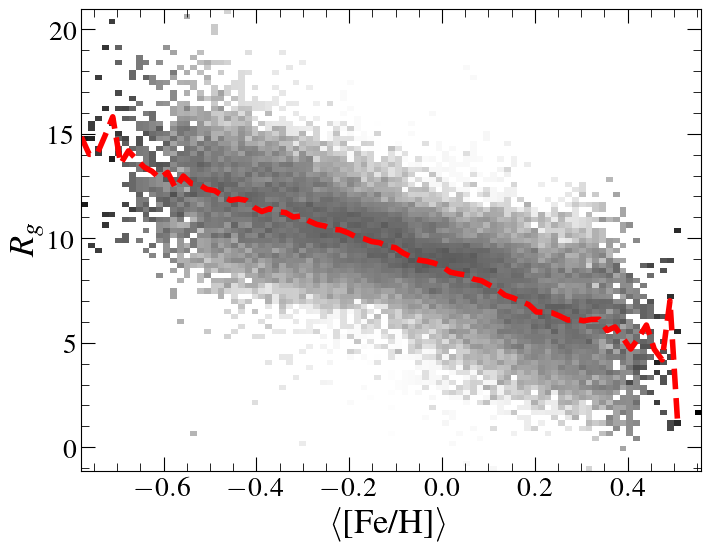

In [351]:
xs = np.linspace(-0.8,0.4, 128)
lzs = -2000*xs + 2000

plt.figure(figsize=(8,6))
biny = np.linspace(np.min(Rg[wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.max(Rg[wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)
binx = np.linspace(np.nanmin(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.nanmax(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)    
hist, xedges, yedges = np.histogram2d(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)],Rg[wmask_all&(np.abs(abun)<3)&(Lz>0)], bins=91)
hist = hist.T
hist = hist / hist.sum(axis=0)[None]
    
means,zs = running_mean(data['FE_H'][wmask_all&(abun>-10)&(Lz>0)],Rg[wmask_all&(abun>-10)&(Lz>0)])

# plt.plot(xs, lzs, lw=2. ,c='b', ls='dotted')
plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
# plt.xlim(10,70)
# plt.xlim(-0.5,0.5)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$\langle$[Fe/H]$\rangle$', fontsize=25)
plt.ylabel(r'$R_g$', fontsize=25)

Text(0, 0.5, '$R$')

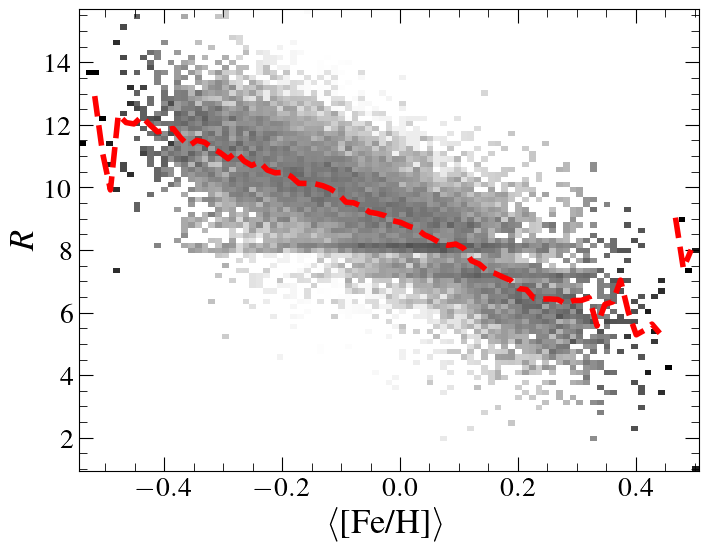

In [327]:
xs = np.linspace(-0.8,0.4, 128)
lzs = -2000*xs + 2000

plt.figure(figsize=(8,6))
biny = np.linspace(np.min(Rgal[wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.max(Rgal[wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)
binx = np.linspace(np.nanmin(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.nanmax(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)    
hist, xedges, yedges = np.histogram2d(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)],Rgal[wmask_all&(np.abs(abun)<3)&(Lz>0)], bins=91)
hist = hist.T
hist = hist / hist.sum(axis=0)[None]
    
means,zs = running_mean(data['FE_H'][wmask_all&(abun>-10)&(Lz>0)],Rgal[wmask_all&(abun>-10)&(Lz>0)])

# plt.plot(xs, lzs, lw=2. ,c='b', ls='dotted')
plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
# plt.xlim(10,70)
# plt.xlim(-0.5,0.5)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$\langle$[Fe/H]$\rangle$', fontsize=25)
plt.ylabel(r'$R$', fontsize=25)

In [320]:
from astropy.constants import G
rads = np.linspace(4,14,21)
delta = (rads[1]-rads[0])/2.
dens = np.zeros((len(rads)))

for indx, i in enumerate(rads):
    mask_bin = (Rgal>i)&(Rgal<i+delta)
    fehs = np.nanmean(data['FE_H'][wmask&mask_bin])
    lzs = (-2000* fehs + 2000)*((u.kpc *u.km)/u.s)
    scale = 1./(4.*np.pi*G)
    rho = scale * 2.*(lzs**2/(i*u.kpc)**4)
    rho = rho.to(u.solMass/u.pc**3)
    dens[indx] = rho.value

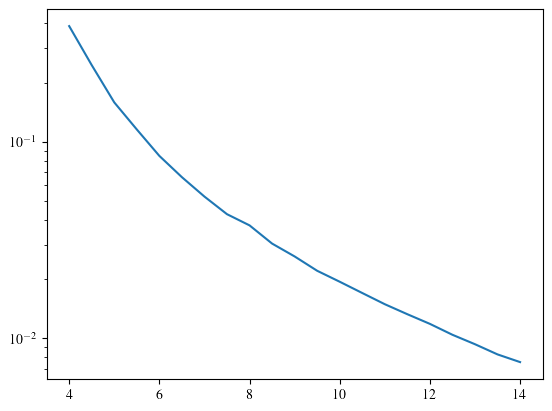

In [322]:
plt.plot(rads, dens)
plt.yscale('log')

In [352]:
np.save('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-last',wmask_all)

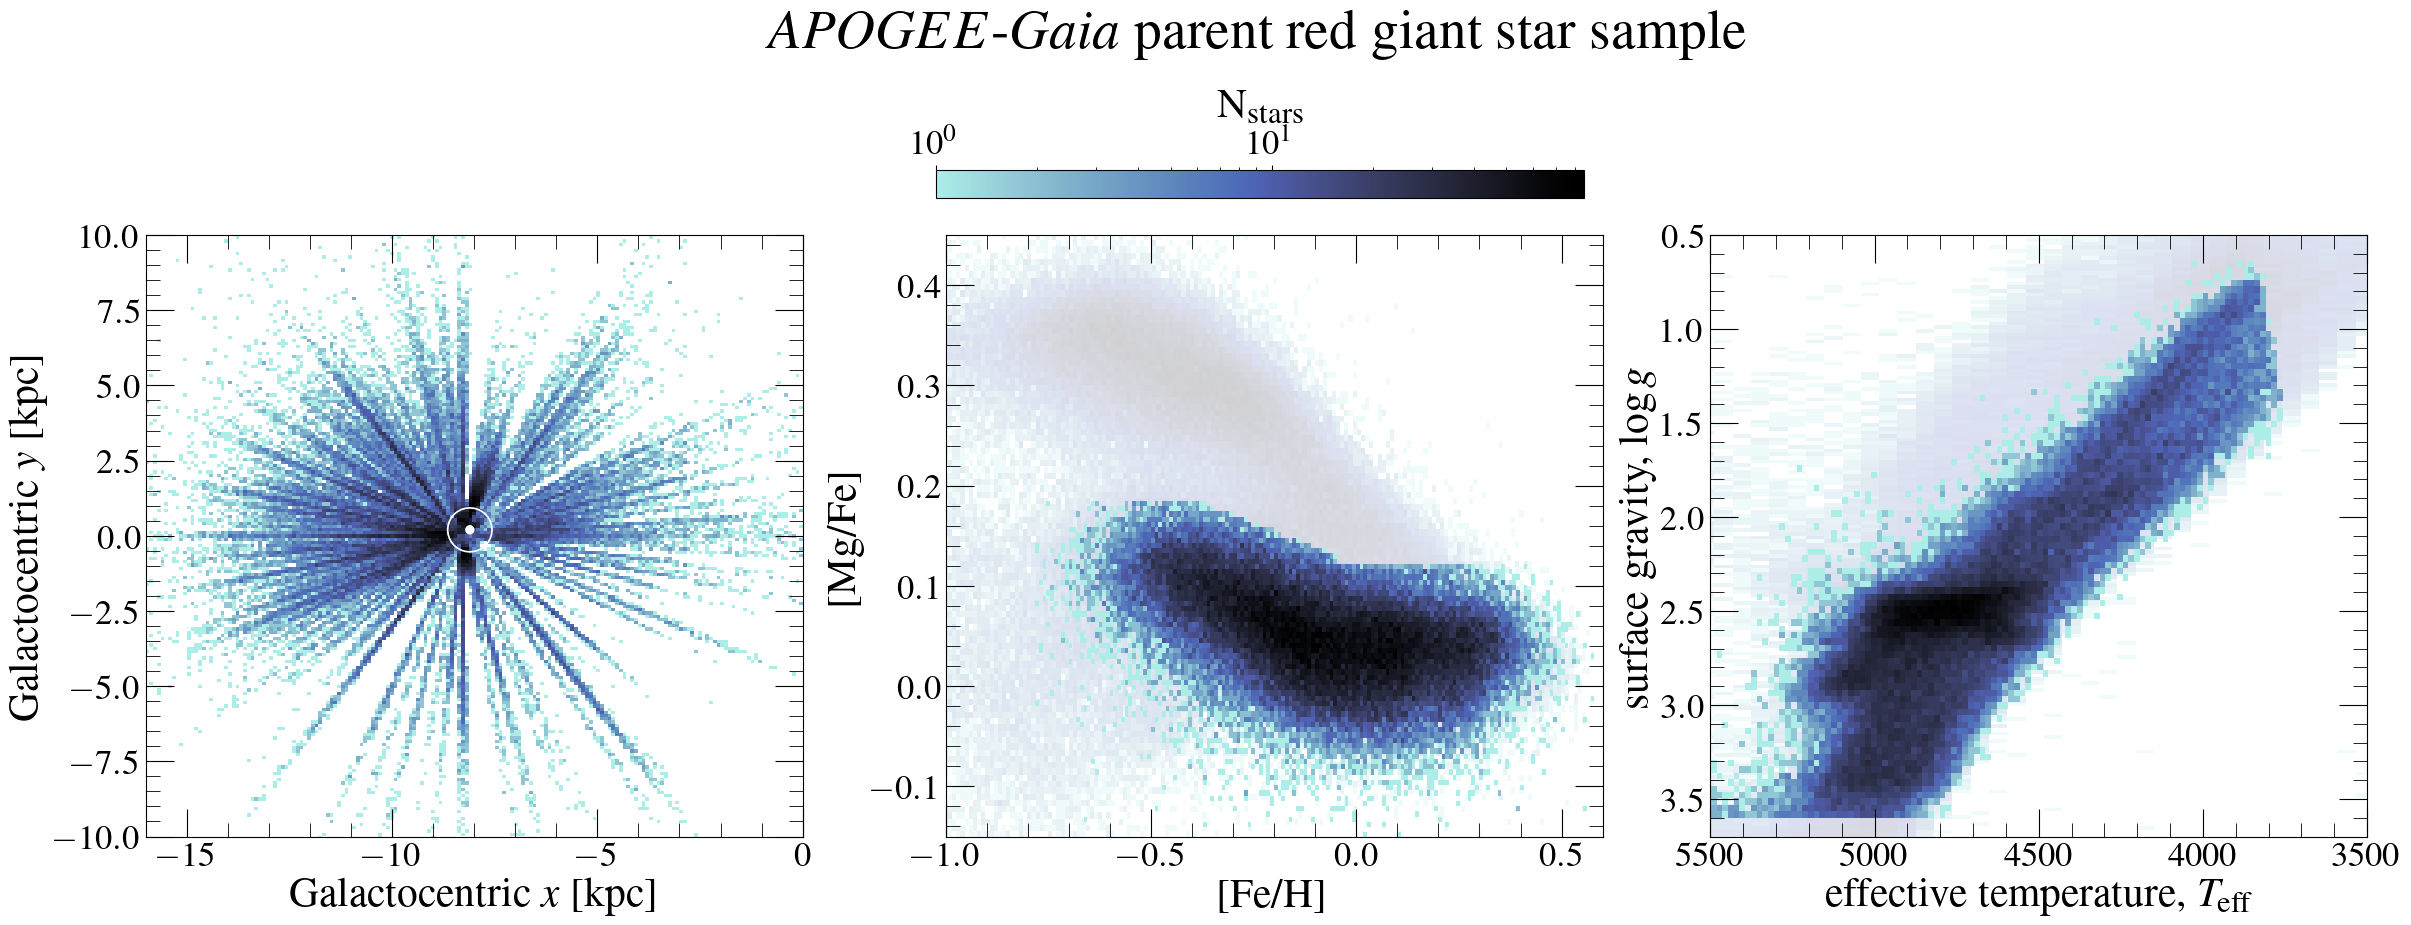

In [281]:
from matplotlib.colors import LogNorm
## from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')
fig.suptitle('$APOGEE$-$Gaia$ parent red giant star sample',fontsize=40,x=0.52,y=1.3)

plt.subplot(1,3,1)
plt.hist2d(data['xyz'][:,0][wmask_all],data['xyz'][:,1][wmask_all],bins=300,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
# plt.scatter(-8.125,0.,c='white',s=100)
plt.text(-8.7,-0.35,'$\odot$',fontsize=50,color='white',fontweight='bold')
plt.xlabel('Galactocentric $x$ [kpc]', fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]', fontsize=30)
plt.xlim(-16,0)
plt.ylim(-10.,10.)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
# plt.title('APOGEE-$Gaia$ parent red giant star sample', fontsize=35, x=0.5,y=1.3)
plt.hist2d(data['FE_H'][mask&(data['FE_H']>-10)&(data['MG_FE']>-10)],data['MG_FE'][mask&(data['FE_H']>-10)&(data['MG_FE']>-10)],bins=300,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2,rasterized=True)
plt.hist2d(data['FE_H'][wmask_all&(data['FE_H']>-10)&(data['MG_FE']>-10)],data['MG_FE'][wmask_all&(data['FE_H']>-10)&(data['MG_FE']>-10)],bins=150,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Mg/Fe]', fontsize=30)
plt.xlim(-1,0.6)
plt.ylim(-0.15,0.45)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.3875, 1.03, 0.27,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(1,3,3)
plt.hist2d(data['TEFF'][(data['TEFF']>-10)],data['LOGG'][(data['TEFF']>-10)],bins=300,cmap=cm.sapphire_r,norm=LogNorm(),alpha=0.2,rasterized=True)
plt.hist2d(data['TEFF'][wmask_all],data['LOGG'][wmask_all],bins=100,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('effective temperature, $T_{\mathrm{eff}}$', fontsize=30)
plt.ylabel('surface gravity, $\log g$', fontsize=30)
plt.xlim(5500,3500)
plt.ylim(3.7,0.5)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data.pdf',dpi=250, bbox_inches = 'tight')


In [282]:
xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['SI_FE'],data['FE_H'], data['MN_FE'], data['NI_FE']])[0].T
xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Fe/H]', '[Mn/Fe]','[Ni/Fe]']
vmins = [-0.0,-0.1,-0.05,-0.4,-0.05, -0.05]
vmaxs = [0.12,0.15,0.1,0.4,0.15, 0.1]

# omask = (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<3)&(np.abs(vz)<20*u.kpc/u.Gyr)&(Rgal<15)&(Rgal>5)&(np.abs(vR)<125) # vr of 50 here caused we checked deltaR in Vr and found it is around 50
# wmask_all = wmask&omask&age_mask
# print(len(data[wmask_all]))

In [283]:
def running_mean(xs, ys):
    grid = np.linspace(np.min(xs),np.max(xs),80)
    delta = grid[1]-grid[0]
    vals = np.zeros((len(grid)))
    
    for indx, i in enumerate(grid):
        mask = (xs<(i+delta))&(xs>i)
        vals[indx] = np.mean(ys[mask])
    return vals,grid
    

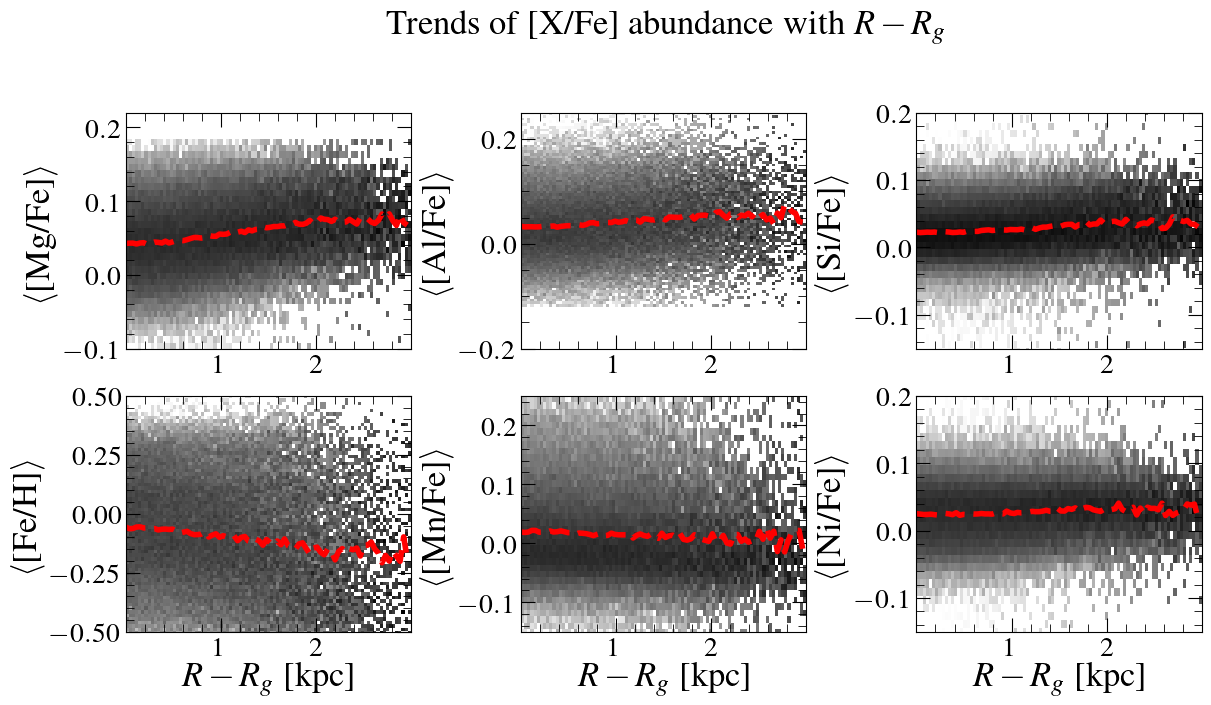

In [284]:
from scipy import stats
from matplotlib.colors import LogNorm

nbins=51
stat='mean'
fig = plt.figure(figsize=(12,6),constrained_layout=True,facecolor='white')
fig.suptitle('Trends of [X/Fe] abundance with $R-R_g$',fontsize=25,x=0.55,y=1.15)

all_axes = []

x_ = np.abs(deltaR)

for indx, i in enumerate(xfe):
    
    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)

    abun = i
    norm = 1
    binx = np.linspace(np.min(x_[wmask_all&(np.abs(abun)<3)]),np.max(x_[wmask_all&(np.abs(abun)<3)]),nbins)
    biny = np.linspace(np.nanmin(i[wmask_all&(np.abs(abun)<3)]),np.nanmax(i[wmask_all&(np.abs(abun)<3)]),nbins)    
    hist, xedges, yedges = np.histogram2d(x_[wmask_all&(np.abs(abun)<3)],i[wmask_all&(np.abs(abun)<3)], bins=91)
    hist = hist.T
#     hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
    hist = hist / hist.sum(axis=0)[None]
    
    means,zs = running_mean(x_[wmask_all&(abun>-10)],i[wmask_all&(abun>-10)])
    # means_young,zs_young = running_mean(deltaR[wmask1&(abun>-10)],i[wmask1&(abun>-10)])
    # means_mid,zs_mid = running_mean(deltaR[wmask2&(abun>-10)],i[wmask2&(abun>-10)])
    # means_old,zs_old = running_mean(deltaR[wmask3&(abun>-10)],i[wmask3&(abun>-10)])
    
    plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
    plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
    # plt.plot(zs_young,means_young,c='aquamarine',lw=4,ls='dotted', label='Age $< 3$')
    # plt.plot(zs_mid,means_mid,c='dodgerblue',lw=4,ls='dotted', label='$3<$ Age $< 6$')
    # plt.plot(zs_old,means_old,c='navy',lw=4,ls='dotted', label='Age $> 6$')
    # plt.legend(loc='upper right', fontsize=8, frameon=False, ncols=2)
#     plt.ylim(-0.1,0.2)
    plt.ylim(vmins[indx]-0.1,vmaxs[indx]+0.1)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()
    plt.ylabel(r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$', fontsize=25)


all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[-1,:]:
    ax.set_xlabel('$R-R_g$ [kpc]', fontsize=25,labelpad=0.1)

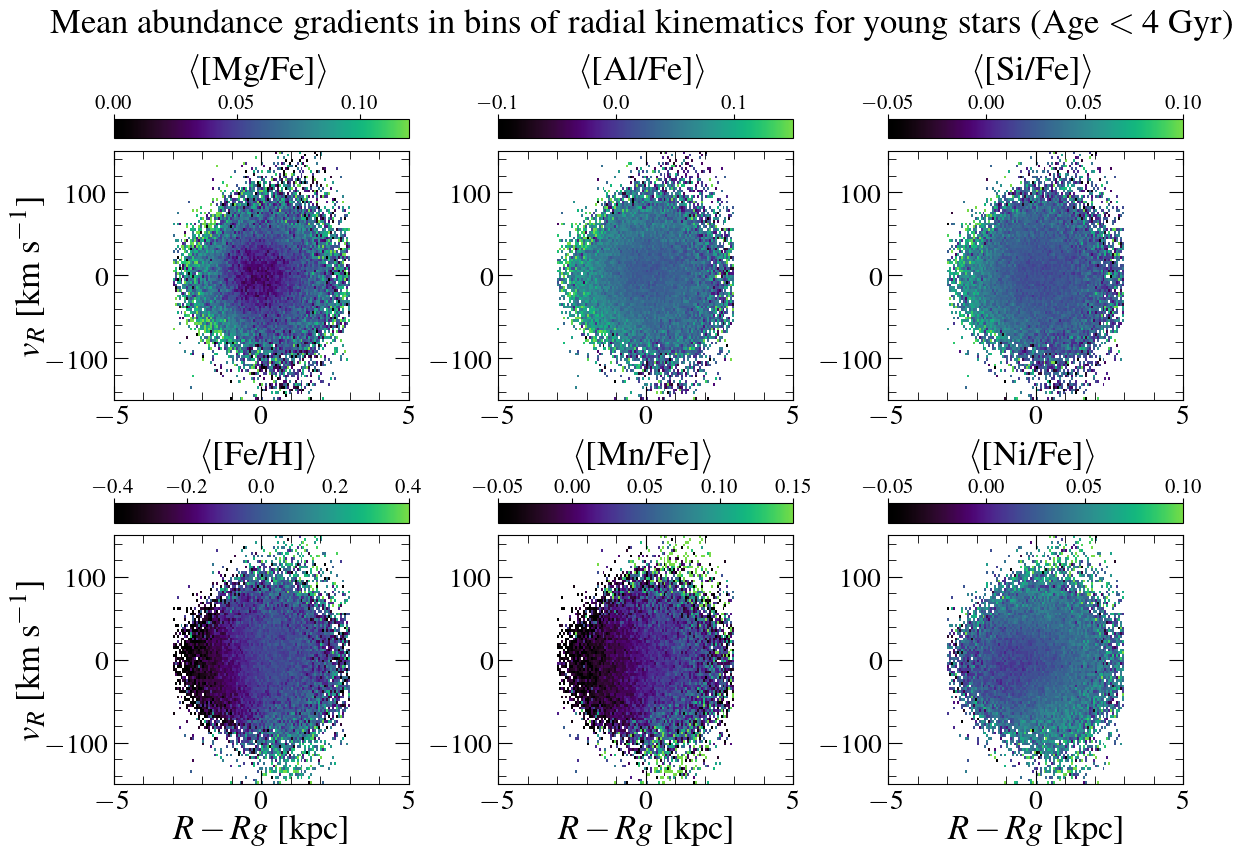

In [286]:
from scipy import stats

nbins=91
stat='mean'
fig = plt.figure(figsize=(12,8),constrained_layout=True,facecolor='white')
fig.suptitle('Mean abundance gradients in bins of radial kinematics for young stars (Age $<4$ Gyr)',fontsize=25,x=0.53,y=1.05)
all_axes = []
for indx, i in enumerate(xfe):

    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)
#     mask_plot = (Rg>8)&(Rg<10)
    abun = i
    binx = np.linspace(np.min(deltaR[wmask_all&(abun>-10)]),np.max(deltaR[wmask_all&(abun>-10)]),nbins)
    biny = np.linspace(np.min(vR[wmask_all&(abun>-10)]),np.max(vR[wmask_all&(abun>-10)]),nbins)    
    hist = stats.binned_statistic_2d(deltaR[wmask_all&(abun>-10)],vR[wmask_all&(abun>-10)], i[wmask_all&(abun>-10)], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=vmins[indx],vmax=vmaxs[indx])
    plt.xlim(-5,5)
    plt.ylim(-150,150)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25,labelpad=10)
    cbar.ax.tick_params(labelsize=15,pad=1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[:,0]:
    ax.set_ylabel('$v_{R}$ [km s$^{-1}$]', fontsize=25,labelpad=0.1)
for ax in all_axes[1,:]:
    ax.set_xlabel('$R-Rg$ [kpc]', fontsize=25,labelpad=0.1)

    # plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/gradients-young-magma.pdf',dpi=250, bbox_inches = 'tight')



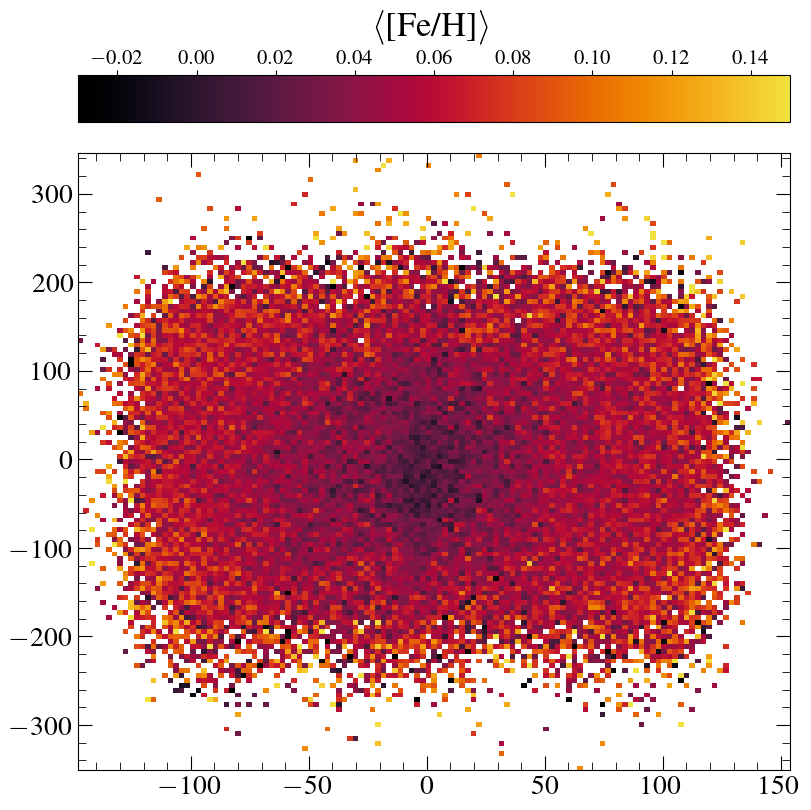

In [126]:
abun = data['MG_FE']
nbins = 128
wmask = wmask_all
from scipy import stats
fig = plt.figure(figsize=(8,8),constrained_layout=True,facecolor='white',rasterized=True)

binx = np.linspace(np.min(LR[wmask&(abun>-10)&(~np.isnan(LR))]),np.max(LR[wmask&(abun>-10)&(~np.isnan(LR))]),nbins)
biny = np.linspace(np.min(Lphi[wmask&(abun>-10)&(~np.isnan(LR))]),np.max(Lphi[wmask&(abun>-10)&(~np.isnan(LR))]),nbins)    
hist = stats.binned_statistic_2d(LR[wmask&(abun>-10)&(~np.isnan(LR))],Lphi[wmask&(abun>-10)&(~np.isnan(LR))], abun[wmask&(abun>-10)&(~np.isnan(LR))], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember, vmin=-0.03,vmax=0.15)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.xlabel('Galactrocentric $x$ [kpc]', fontsize=25)
# plt.ylabel('Galactrocentric $y$ [kpc]', fontsize=25)
cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$[Fe/H]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

In [ ]:
# cnfe = np.log10(10**(data['C_FE']+data['FE_H']+8.39) + 10**(data['N_FE']+data['FE_H']+7.78)) - np.log10(10.**8.39 + 10.**7.78) - data['FE_H']

# # find the Suns Rg
# x_sun, y_sun, z_sun = np.array([-8.275, 0, 0.0208])
# vx_sun, vy_sun, vz_sun = np.array([12.9, 245.6, 7.78])
# Lz_sun = x_sun*vy_sun
# Rg_sun = np.abs(Lz_sun)/229.

# # choose the elements we want to show
# xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['SI_FE'],data['FE_H'], data['MN_FE'], data['NI_FE']])[0].T
# xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Fe/H]', '[Mn/Fe]','[Ni/Fe]']
# vmins = [-0.06,-0.1,-0.05,-0.4,-0.05, -0.05]
# vmaxs = [0.12,0.15,0.1,0.25,0.15, 0.1]

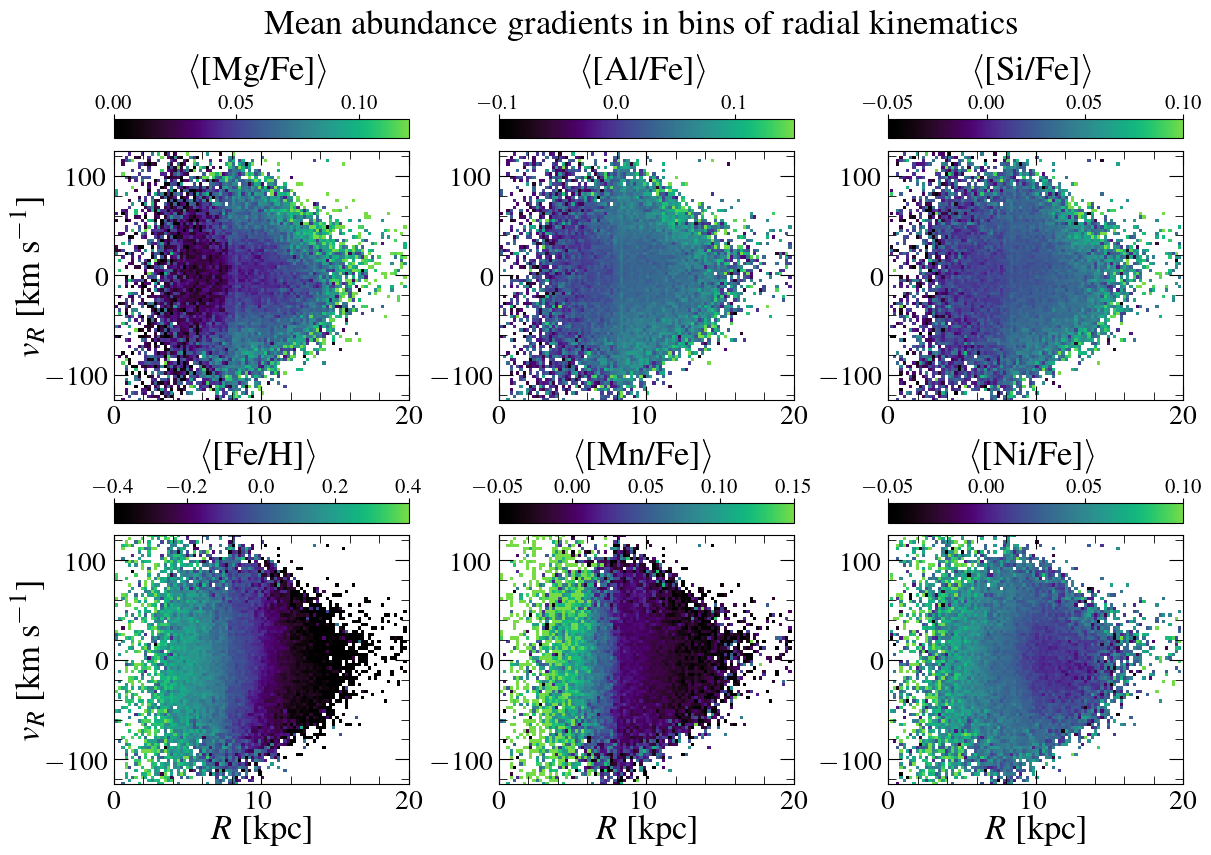

In [287]:
from scipy import stats

nbins=91
stat='mean'
fig = plt.figure(figsize=(12,8),constrained_layout=True,facecolor='white',rasterized=True)
fig.suptitle('Mean abundance gradients in bins of radial kinematics',fontsize=25,x=0.53,y=1.05)
all_axes = []
for indx, i in enumerate(xfe):

    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)
#     mask_plot = (Rg>8)&(Rg<10)
    abun = i
    binx = np.linspace(np.min(Rgal[wmask_all&(abun>-10)]),np.max(Rgal[wmask_all&(abun>-10)]),nbins)
    biny = np.linspace(np.min(vR[wmask_all&(abun>-10)]),np.max(vR[wmask_all&(abun>-10)]),nbins)    
    hist = stats.binned_statistic_2d(Rgal[wmask_all&(abun>-10)],vR[wmask_all&(abun>-10)], i[wmask_all&(abun>-10)], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=vmins[indx],vmax=vmaxs[indx])
    plt.xlim(0,20)
    plt.ylim(-125,125)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25,labelpad=10)
    cbar.ax.tick_params(labelsize=15,pad=1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[:,0]:
    ax.set_ylabel('$v_{R}$ [km s$^{-1}$]', fontsize=25,labelpad=0.1)
for ax in all_axes[1,:]:
    ax.set_xlabel('$R$ [kpc]', fontsize=25,labelpad=0.1)

    # plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/gradients-all.pdf',dpi=250, bbox_inches = 'tight')


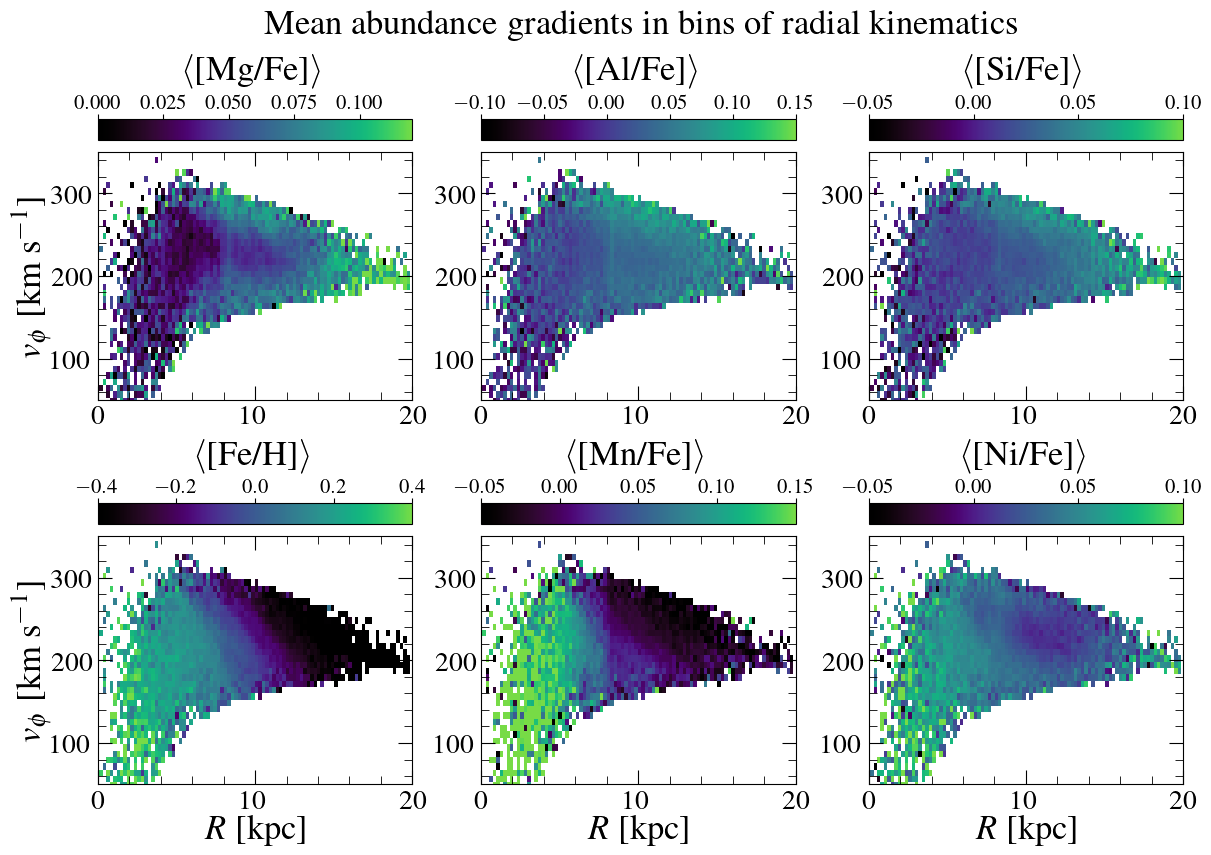

In [288]:
from scipy import stats

nbins=91
stat='mean'
fig = plt.figure(figsize=(12,8),constrained_layout=True,facecolor='white',rasterized=True)
fig.suptitle('Mean abundance gradients in bins of radial kinematics',fontsize=25,x=0.53,y=1.05)
all_axes = []
for indx, i in enumerate(xfe):

    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)
#     mask_plot = (Rg>8)&(Rg<10)
    abun = i
    binx = np.linspace(np.min(Rgal[wmask_all&(abun>-10)]),np.max(Rgal[wmask_all&(abun>-10)]),nbins)
    biny = np.linspace(np.min(vt[wmask_all&(abun>-10)]),np.max(vt[wmask_all&(abun>-10)]),nbins)    
    hist = stats.binned_statistic_2d(Rgal[wmask_all&(abun>-10)],vt[wmask_all&(abun>-10)], i[wmask_all&(abun>-10)], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=vmins[indx],vmax=vmaxs[indx])
    plt.xlim(0,20)
    plt.ylim(50,350)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25,labelpad=10)
    cbar.ax.tick_params(labelsize=15,pad=1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[:,0]:
    ax.set_ylabel('$v_{\phi}$ [km s$^{-1}$]', fontsize=25,labelpad=0.1)
for ax in all_axes[1,:]:
    ax.set_xlabel('$R$ [kpc]', fontsize=25,labelpad=0.1)

    # plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/gradients-all.pdf',dpi=250, bbox_inches = 'tight')


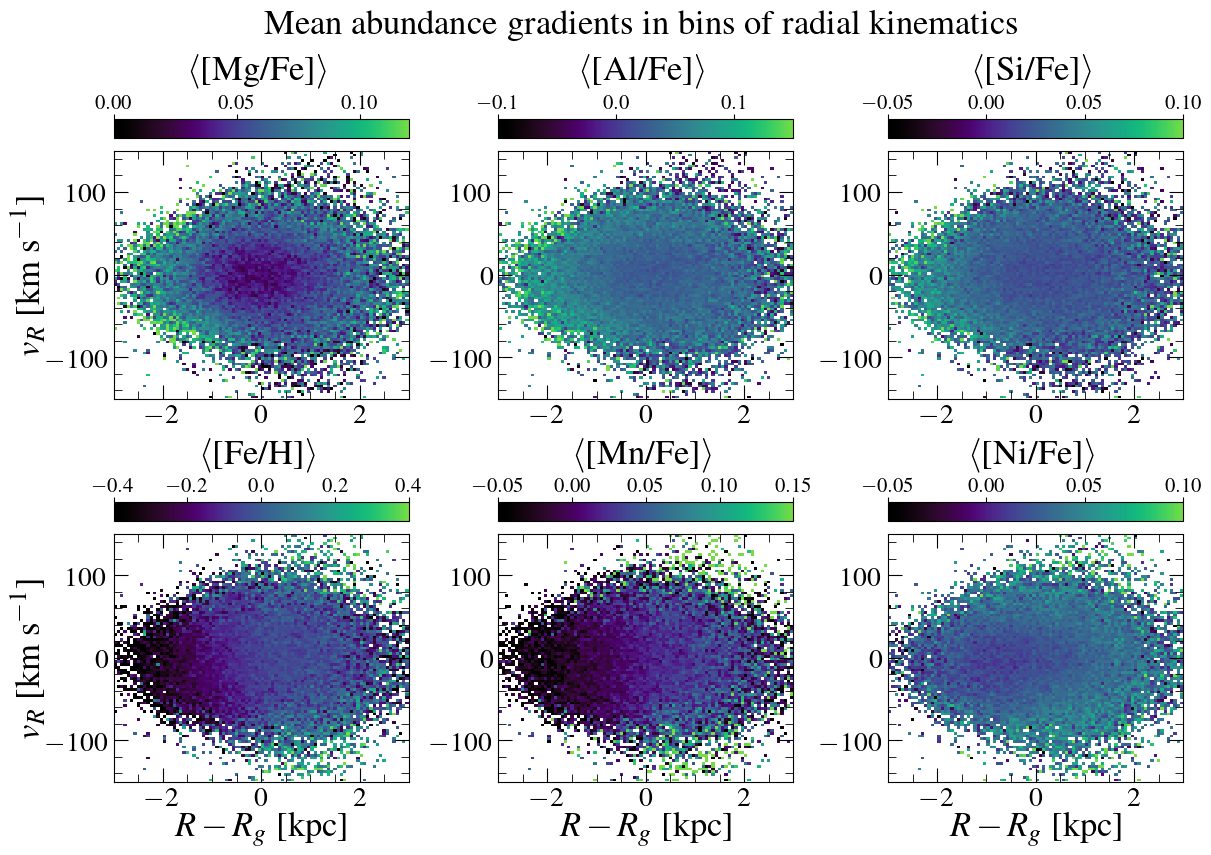

In [289]:
from scipy import stats

nbins=91
stat='mean'
fig = plt.figure(figsize=(12,8),constrained_layout=True,facecolor='white',rasterized=True)
fig.suptitle('Mean abundance gradients in bins of radial kinematics',fontsize=25,x=0.53,y=1.05)
all_axes = []
for indx, i in enumerate(xfe):

    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)
#     mask_plot = (Rg>8)&(Rg<10)
    abun = i
    binx = np.linspace(np.min(deltaR[wmask_all&(abun>-10)]),np.max(deltaR[wmask_all&(abun>-10)]),nbins)
    biny = np.linspace(np.min(vR[wmask_all&(abun>-10)]),np.max(vR[wmask_all&(abun>-10)]),nbins)    
    hist = stats.binned_statistic_2d(deltaR[wmask_all&(abun>-10)],vR[wmask_all&(abun>-10)], i[wmask_all&(abun>-10)], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.lavender,vmin=vmins[indx],vmax=vmaxs[indx])
    plt.xlim(-3,3)
    plt.ylim(-150,150)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25,labelpad=10)
    cbar.ax.tick_params(labelsize=15,pad=1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[:,0]:
    ax.set_ylabel('$v_{R}$ [km s$^{-1}$]', fontsize=25,labelpad=0.1)
for ax in all_axes[1,:]:
    ax.set_xlabel('$R-R_g$ [kpc]', fontsize=25,labelpad=0.1)

    # plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/gradients-all.pdf',dpi=250, bbox_inches = 'tight')


Plot the trends of abundance with $R$

In [154]:
xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['SI_FE'],data['FE_H'], data['MN_FE'], data['NI_FE']])[0].T
xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Fe/H]', '[Mn/Fe]','[Ni/Fe]']
vmins = [-0.05,-0.1,-0.05,-0.4,-0.05, -0.05]
vmaxs = [0.1,0.15,0.1,0.4,0.15, 0.1]

In [155]:
def running_mean(xs, ys):
    grid = np.linspace(np.min(xs),np.max(xs),80)
    delta = grid[1]-grid[0]
    vals = np.zeros((len(grid)))
    
    for indx, i in enumerate(grid):
        mask = (xs<(i+delta))&(xs>i)
        vals[indx] = np.mean(ys[mask])
    return vals,grid
    

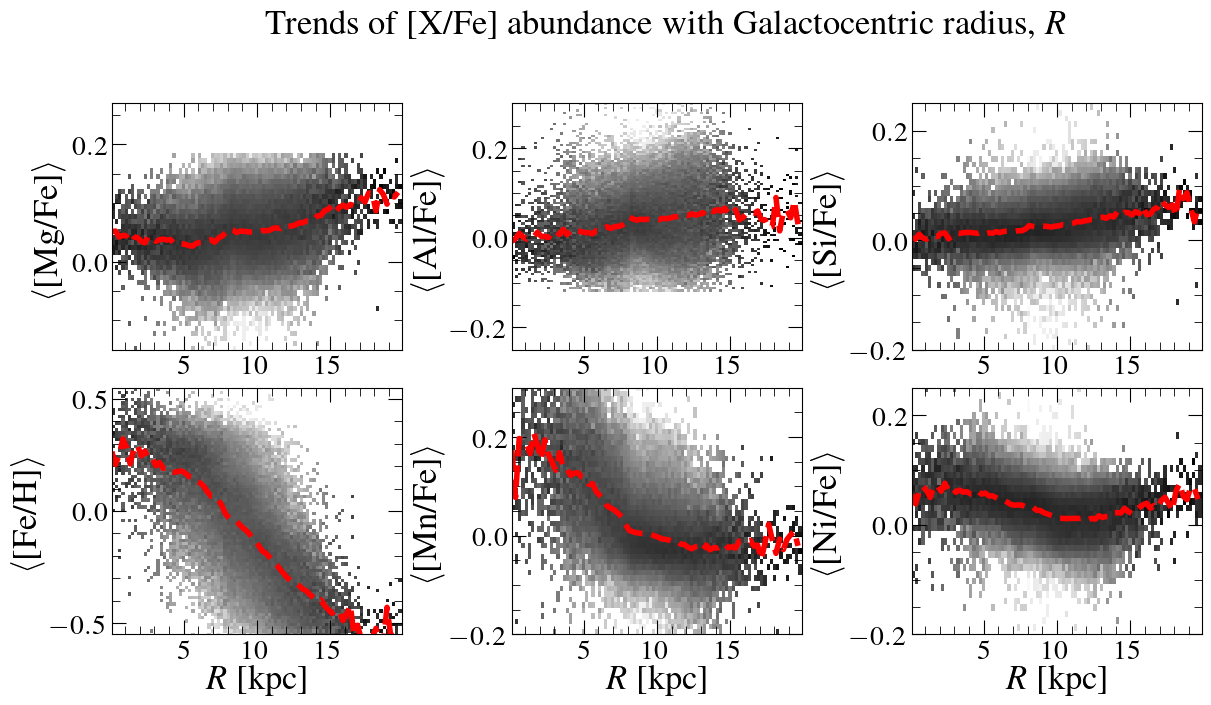

In [290]:
from scipy import stats
from matplotlib.colors import LogNorm

nbins=51
stat='mean'
fig = plt.figure(figsize=(12,6),constrained_layout=True,facecolor='white')
fig.suptitle('Trends of [X/Fe] abundance with Galactocentric radius, $R$',fontsize=25,x=0.55,y=1.15)

all_axes = []

for indx, i in enumerate(xfe):
    
    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)

    abun = i
    norm = 1
    binx = np.linspace(np.min(Rgal[wmask_all&(np.abs(abun)<3)]),np.max(Rgal[wmask_all&(np.abs(abun)<3)]),nbins)
    biny = np.linspace(np.nanmin(i[wmask_all&(np.abs(abun)<3)]),np.nanmax(i[wmask_all&(np.abs(abun)<3)]),nbins)    
    hist, xedges, yedges = np.histogram2d(Rgal[wmask_all&(np.abs(abun)<3)],i[wmask_all&(np.abs(abun)<3)], bins=91)
    hist = hist.T
#     hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
    hist = hist / hist.sum(axis=0)[None]
    
    means,zs = running_mean(Rgal[wmask_all&(abun>-10)],i[wmask_all&(abun>-10)])
    
    plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
    plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
    # plt.plot(zs_young,means_young,c='aquamarine',lw=4,ls='dotted', label='Age $< 3$')
    # plt.plot(zs_mid,means_mid,c='dodgerblue',lw=4,ls='dotted', label='$3<$ Age $< 6$')
    # plt.plot(zs_old,means_old,c='navy',lw=4,ls='dotted', label='Age $> 6$')
    # plt.legend(loc='upper right', fontsize=8, frameon=False, ncols=2)
#     plt.ylim(-0.1,0.2)
    plt.ylim(vmins[indx]-0.15,vmaxs[indx]+0.15)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()
    plt.ylabel(r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$', fontsize=25)


all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[-1,:]:
    ax.set_xlabel('$R$ [kpc]', fontsize=25,labelpad=0.1)

In [291]:
Lz = Rgal * vt

lzR = Lz/Rgal**2
lzRg = Lz/Rg**2

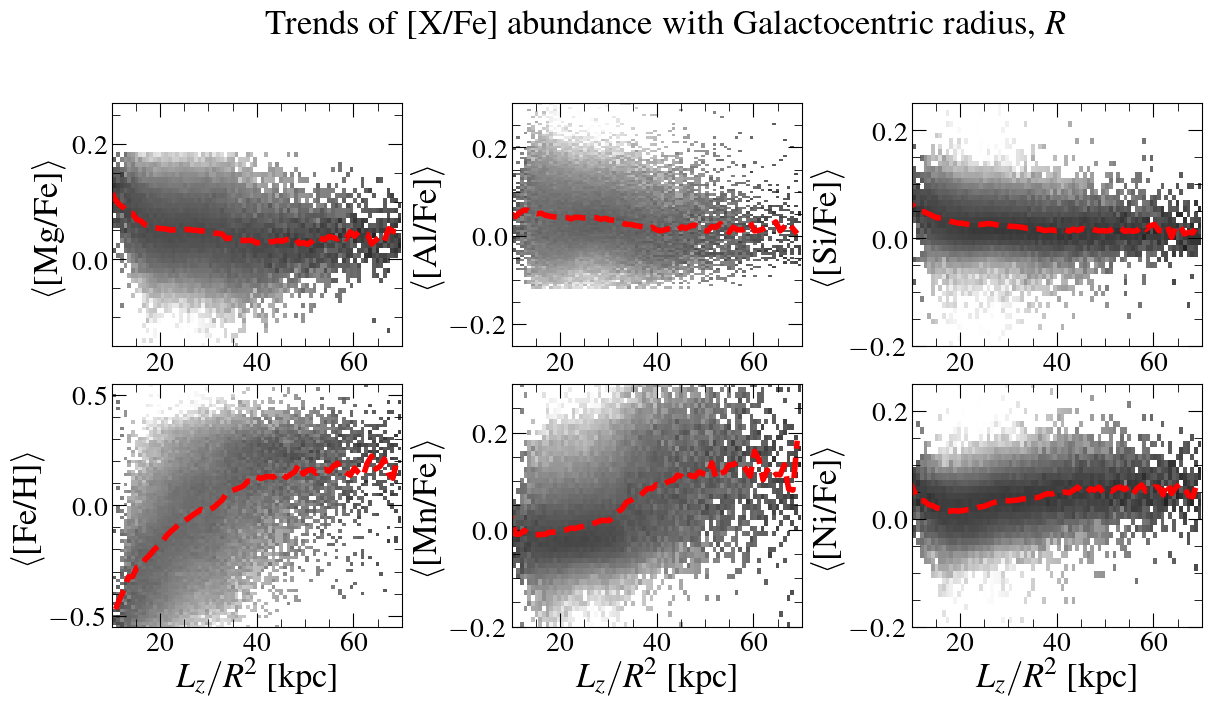

In [292]:
from scipy import stats
from matplotlib.colors import LogNorm

nbins=51
stat='mean'
fig = plt.figure(figsize=(12,6),constrained_layout=True,facecolor='white')
fig.suptitle('Trends of [X/Fe] abundance with Galactocentric radius, $R$',fontsize=25,x=0.55,y=1.15)

all_axes = []

for indx, i in enumerate(xfe):
    
    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)

    abun = i
    norm = 1
    binx = np.linspace(np.min(lzR[wmask_all&(np.abs(abun)<3)&(lzR>0)&(lzR<70)]),np.max(lzR[wmask_all&(np.abs(abun)<3)&(lzR>0)&(lzR<70)]),nbins)
    biny = np.linspace(np.nanmin(i[wmask_all&(np.abs(abun)<3)&(lzR>0)&(lzR<70)]),np.nanmax(i[wmask_all&(np.abs(abun)<3)&(lzR>0)&(lzR<70)]),nbins)    
    hist, xedges, yedges = np.histogram2d(lzR[wmask_all&(np.abs(abun)<3)&(Lz>0)&(lzR<70)],i[wmask_all&(np.abs(abun)<3)&(lzR>0)&(lzR<70)], bins=91)
    hist = hist.T
#     hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
    hist = hist / hist.sum(axis=0)[None]
    
    means,zs = running_mean(lzR[wmask_all&(abun>-10)&(lzR>0)&(lzR<70)],i[wmask_all&(abun>-10)&(lzR>0)&(lzR<70)])
    
    plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
    plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
    # plt.plot(zs_young,means_young,c='aquamarine',lw=4,ls='dotted', label='Age $< 3$')
    # plt.plot(zs_mid,means_mid,c='dodgerblue',lw=4,ls='dotted', label='$3<$ Age $< 6$')
    # plt.plot(zs_old,means_old,c='navy',lw=4,ls='dotted', label='Age $> 6$')
    # plt.legend(loc='upper right', fontsize=8, frameon=False, ncols=2)
#     plt.ylim(-0.1,0.2)
    plt.xlim(10,70)
    plt.ylim(vmins[indx]-0.15,vmaxs[indx]+0.15)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()
    plt.ylabel(r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$', fontsize=25)


all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[-1,:]:
    ax.set_xlabel('$L_z/R^2$ [kpc]', fontsize=25,labelpad=0.1)

Text(0, 0.5, '$L_z$')

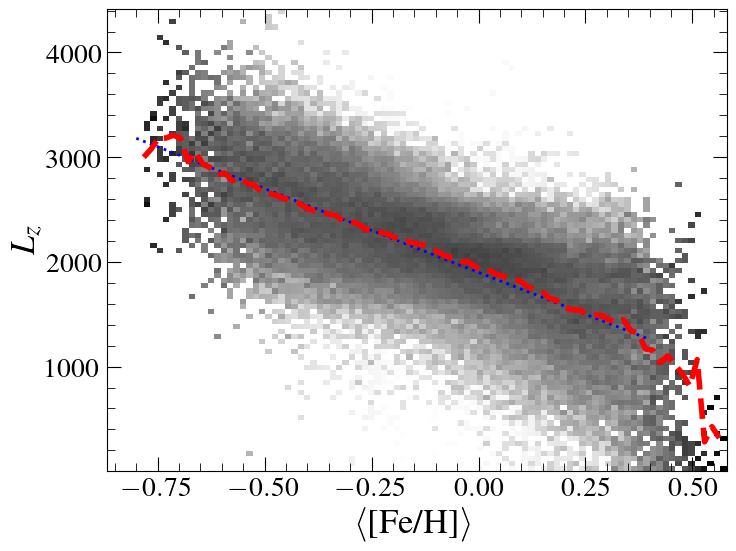

In [293]:
xs = np.linspace(-0.8,0.4, 128)
lzs = -1600*xs + 1900

plt.figure(figsize=(8,6))
biny = np.linspace(np.min(Lz[wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.max(Lz[wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)
binx = np.linspace(np.nanmin(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.nanmax(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)    
hist, xedges, yedges = np.histogram2d(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)],Lz[wmask_all&(np.abs(abun)<3)&(Lz>0)], bins=91)
hist = hist.T
hist = hist / hist.sum(axis=0)[None]
    
means,zs = running_mean(data['FE_H'][wmask_all&(abun>-10)&(Lz>0)],Lz[wmask_all&(abun>-10)&(Lz>0)])

plt.plot(xs, lzs, lw=2. ,c='b', ls='dotted')
plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
# plt.xlim(10,70)
# plt.xlim(-0.5,0.5)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$\langle$[Fe/H]$\rangle$', fontsize=25)
plt.ylabel(r'$L_z$', fontsize=25)

Text(0, 0.5, '$R$')

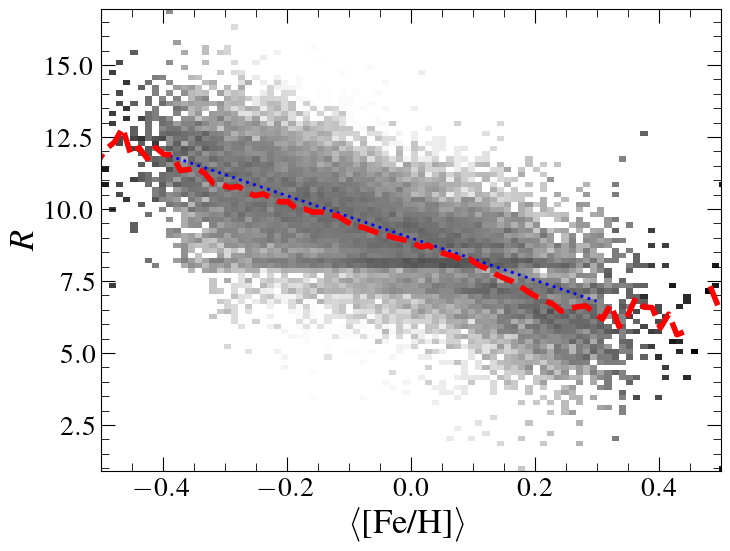

In [241]:
xs = np.linspace(-0.4,0.3, 128)
lzs = -7.33*xs + 9.

plt.figure(figsize=(8,6))
biny = np.linspace(np.min(Rgal[wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.max(Rgal[wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)
binx = np.linspace(np.nanmin(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),np.nanmax(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)]),nbins)    
hist, xedges, yedges = np.histogram2d(data['FE_H'][wmask_all&(np.abs(abun)<3)&(Lz>0)],Rgal[wmask_all&(np.abs(abun)<3)&(Lz>0)], bins=91)
hist = hist.T
hist = hist / hist.sum(axis=0)[None]
    
means,zs = running_mean(data['FE_H'][wmask_all&(abun>-10)&(Lz>0)],Rgal[wmask_all&(abun>-10)&(Lz>0)])

plt.plot(xs, lzs, lw=2. ,c='b', ls='dotted')
plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
plt.plot(zs,means,c='r',lw=4,ls='dashed', label='All')
# plt.xlim(10,70)
plt.xlim(-0.5,0.5)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$\langle$[Fe/H]$\rangle$', fontsize=25)
plt.ylabel(r'$R$', fontsize=25)